In [1]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict, Counter
from sklearn.decomposition import TruncatedSVD
import json
import itertools
from scipy.stats import linregress
import plotly_express as px
from torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
import math
import seaborn as sns
from scipy.signal import savgol_filter

from collections.abc import Callable
import numpy as np
import torch
from datasets import Dataset, load_dataset
from typing import Optional, Tuple
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import final, cast
import pickle
import gc
from scipy.stats import kstest

## Setup

In [2]:
def clean_cache():
    torch.cuda.empty_cache()
    gc.collect()


def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


# Utils
def generate_prompt(dataset, n_ctx: int = 1, batch: int = 1) -> torch.Tensor:
    """Generate a prompt from the dataset."""
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)
    return next(iter(dataloader))["input_ids"][:, :n_ctx]


def compute_kl_div(logits_ref: torch.Tensor, logits_pert: torch.Tensor) -> torch.Tensor:
    """Compute the KL divergence between the reference and perturbed logprobs."""
    logprobs_ref = F.log_softmax(logits_ref, dim=-1)
    logprobs_pert = F.log_softmax(logits_pert, dim=-1)
    temp_output = F.kl_div(
        logprobs_ref, logprobs_pert, log_target=True, reduction="none"
    )
    return temp_output.sum(dim=-1)


def get_random_activation(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompt = generate_prompt(dataset, n_ctx=n_ctx)
    _, cache = model.run_with_cache(rand_prompt)
    return cache[layer][:, pos, :].to("cpu").detach()


def load_pretokenized_dataset(
    path: str,
    split: str,
) -> Dataset:
    dataset = load_dataset(path, split=split)
    dataset = cast(Dataset, dataset)
    return dataset.with_format("torch")


def get_random_activations(
    model: HookedTransformer, dataset: Dataset, n_ctx: int, layer: str, pos, n_samples
) -> torch.Tensor:
    """Get a random activation from the dataset."""
    rand_prompts = torch.cat(
        [generate_prompt(dataset, n_ctx=n_ctx) for _ in range(n_samples)]
    )
    _, cache = model.run_with_cache(rand_prompts)
    return cache[layer][:, pos, :].to("cpu").detach()


def cosine_similarity(a, b):
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()


def setup_random_sampling_data_cov():
    data_mean = torch.tensor(np.load("observations_layer1/data_mean.npy"))
    data_cov = torch.tensor(np.load("observations_layer1/data_cov.npy"))
    distrib = MultivariateNormal(data_mean, data_cov)
    return distrib

In [3]:
@dataclass
class ExperimentConfig:
    n_ctx: int
    perturbation_layer: str
    read_layer: str
    perturbation_pos: slice
    n_steps: int
    perturbation_range: Tuple[float, float]
    seed: Optional[int] = None
    dataloader_batch_size: Optional[int] = None
    mean_batch_size: Optional[int] = None


class Reference:
    def __init__(
        self,
        model: HookedTransformer,
        prompt: torch.Tensor,
        perturbation_layer: str,
        read_layer: str,
        perturbation_pos: slice,
        n_ctx: int,
    ):
        self.model = model
        _, n_ctx_prompt = prompt.shape
        assert (
            n_ctx == n_ctx_prompt
        ), f"n_ctx {n_ctx} must match prompt n_ctx {n_ctx_prompt}"
        self.prompt = prompt
        logits, cache = model.run_with_cache(prompt)
        self.logits = logits.to("cpu").detach()
        self.cache = cache.to("cpu")
        self.act = self.cache[perturbation_layer][:, perturbation_pos]
        self.perturbation_layer = perturbation_layer
        self.read_layer = read_layer
        self.perturbation_pos = perturbation_pos
        self.n_ctx = n_ctx

In [4]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=9555,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0, 1),
    n_steps=100,
    mean_batch_size=512,
)

In [5]:
set_seed(cfg.seed)

In [6]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [7]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [8]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[cfg.perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

## Replication

In [9]:
def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def find_blowup_max_slope(dists, min_slope_threshold=0.02, num_steps=100):
    steps = list(range(len(dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = dists[i] - dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    if not any(np.array(slopes) > min_slope_threshold):
        return num_steps - 1

    ms_step = np.argsort(np.nan_to_num(slopes))[::-1][0]
    return ms_step


def calculate_auc(values):
    # Create x values corresponding to the indices of the values
    x = np.arange(len(values))

    # Use numpy's trapezoidal rule to calculate the area under the curve
    auc = np.trapz(values, x)

    return auc


def max_space_ratio_step(values):
    aucs = []
    for i in range(1, len(values)):
        auc = calculate_auc(values[:i])
        if auc == 0:
            aucs.append(0)
            continue
        triangle_area = (values[i - 1] * i) / 2
        aucs.append(triangle_area / auc)
    return np.argmax(aucs[5:]) + 5


def load_graph_pickle(filename):
    """Load the graph using pickle."""
    with open(filename, "rb") as f:
        return pickle.load(f)

### Other act vs random

In [13]:
results = {"other_act": {"l2": [], "ms": []}, "random": {"l2": [], "ms": []}}

In [15]:
metadata, activations = [], []

pert_type = "random"
n_files = 5

for path in sorted(glob(f"replications/{pert_type}_metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"replications/{pert_type}_acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [16]:
for idx, m in enumerate(metadata):
    steps = m["steps_metadata"]
    pert_l2 = [s["read_layer_l2_norm"] for s in steps]
    results[pert_type]["l2"].extend(pert_l2)
    ms = find_blowup_max_slope(pert_l2)
    results[pert_type]["ms"].append(ms)

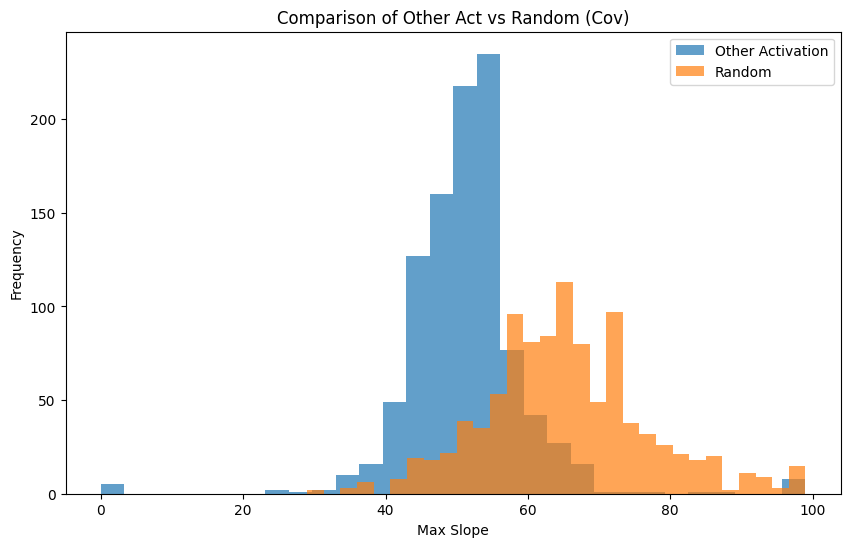

In [17]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot both histograms
plt.hist(results["other_act"]["ms"], bins=30, alpha=0.7, label="Other Activation")
plt.hist(results["random"]["ms"], bins=30, alpha=0.7, label="Random")

# Customize the plot
plt.xlabel("Max Slope")
plt.ylabel("Frequency")
plt.title("Comparison of Other Act vs Random (Cov)")
plt.legend()

# Show the plot
plt.show()

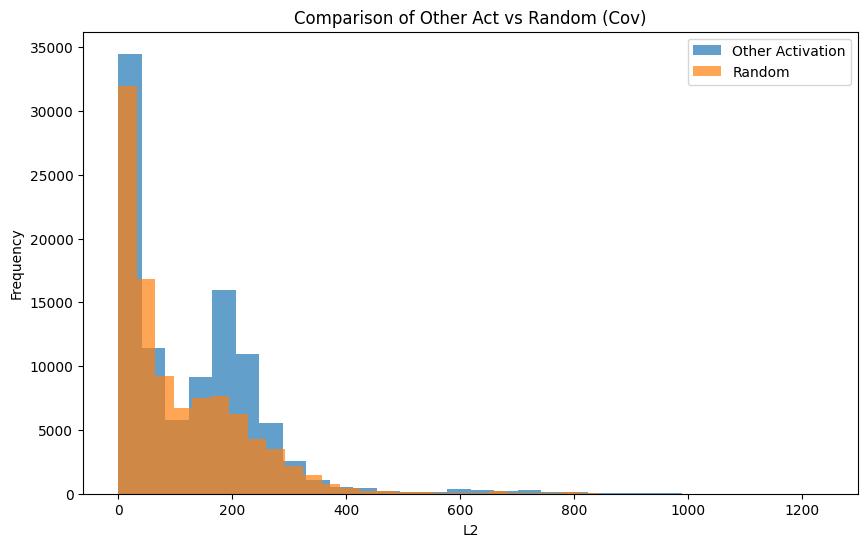

In [22]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot both histograms
plt.hist(results["other_act"]["l2"], bins=30, alpha=0.7, label="Other Activation")
plt.hist(results["random"]["l2"], bins=30, alpha=0.7, label="Random")

# Customize the plot
plt.xlabel("L2")
plt.ylabel("Frequency")
plt.title("Comparison of Other Act vs Random (Cov)")
plt.legend()

# Show the plot
plt.show()

In [20]:
kstest(results["other_act"]["ms"], results["random"]["ms"])

KstestResult(statistic=0.635, pvalue=1.1875381285669299e-189, statistic_location=57, statistic_sign=1)

In [21]:
kstest(results["other_act"]["l2"], results["random"]["l2"])

KstestResult(statistic=0.12663999999999997, pvalue=0.0, statistic_location=152.1401, statistic_sign=-1)

### Real vs Synthetic

In [10]:
distrib = setup_random_sampling_data_cov()
non_dead_feat_ids = np.where(sparsities[cfg.perturbation_layer].cpu().numpy() > -10)[0]

In [11]:
def min_max_scale(vector, feature_range=(0, 1)):
    """
    Perform min-max scaling on a vector.

    Args:
    vector (numpy.ndarray): Input vector to be scaled
    feature_range (tuple): The desired range of transformed data (default: (0, 1))

    Returns:
    numpy.ndarray: Scaled vector
    """
    min_val, max_val = feature_range

    X_std = (vector - vector.min()) / (vector.max() - vector.min())
    X_scaled = X_std * (max_val - min_val) + min_val

    return X_scaled


def custom_spread_scale(vector, target_min=0, target_max=1, center_value=0):
    """
    Scale a vector centered around a specific value to a target range.

    Args:
    vector (numpy.ndarray): Input vector to be scaled
    target_min (float): Minimum value of the target range (default: 0)
    target_max (float): Maximum value of the target range (default: 1)
    center_value (float): The value around which the original vector is centered (default: 0)

    Returns:
    numpy.ndarray: Scaled vector
    """
    # Shift the vector so that center_value becomes 0
    shifted_vector = vector - center_value

    # Find the maximum absolute value in the shifted vector
    max_abs_value = np.max(np.abs(shifted_vector))

    # Scale the shifted vector to [-1, 1] range
    normalized_vector = shifted_vector / max_abs_value

    # Scale to the target range
    scaled_vector = (normalized_vector + 1) / 2 * (target_max - target_min) + target_min

    return scaled_vector


def plot_distributions(ms_other, ms_random, ms_synth):
    plt.figure(figsize=(10, 8))

    # Histogram
    plt.subplot(2, 1, 1)

    # Determine common bins
    all_data = np.concatenate([ms_other, ms_random, ms_synth])
    bins = np.linspace(min(all_data), max(all_data), 30)

    # Plot histograms with common bins and reduced alpha
    plt.hist(
        ms_other,
        bins=bins,
        alpha=0.7,
        label="Other Activation",
        density=True,
        color="tab:orange",
    )
    plt.hist(
        ms_random, bins=bins, alpha=0.7, label="Random", density=True, color="tab:blue"
    )
    plt.hist(
        ms_synth,
        bins=bins,
        alpha=0.7,
        label="Synthetic",
        density=True,
        color="tab:green",
    )

    plt.title("Histogram Comparison")
    plt.legend()
    plt.xlabel("Value")
    plt.ylabel("Density")

    plt.xticks(np.arange(0, 101, 10))

    # CDF
    colors = ["tab:orange", "tab:blue", "tab:green"]
    plt.subplot(2, 1, 2)
    for i, (data, label) in enumerate(
        zip([ms_other, ms_random, ms_synth], ["ms_other", "ms_random", "ms_synth"])
    ):
        cdf = np.sort(data)
        plt.plot(cdf, np.linspace(0, 1, len(cdf)), label=label, color=colors[i])
    plt.title("Cumulative Distribution Function (CDF)")
    plt.legend()
    plt.xlabel("Value")
    plt.ylabel("Cumulative Probability")

    plt.tight_layout()
    plt.show()


def quantify_similarity(ms_other, ms_random, ms_synth):
    # Compute KS statistics
    ks_other_random, _ = stats.kstest(ms_other, ms_random)
    ks_other_synth, _ = stats.kstest(ms_other, ms_synth)
    ks_synth_random, _ = stats.kstest(ms_synth, ms_random)

    # Convert KS statistic to similarity (1 - KS statistic)
    # Higher values now indicate more similarity
    sim_other_random = 1 - ks_other_random
    sim_other_synth = 1 - ks_other_synth
    sim_synth_random = 1 - ks_synth_random

    print(f"Similarity score (ms_other vs ms_random): {sim_other_random:.4f}")
    print(f"Similarity score (ms_other vs ms_synth): {sim_other_synth:.4f}")
    print(f"Similarity score (ms_synth vs ms_random): {sim_synth_random:.4f}")

    # Compare relative similarities
    if sim_other_synth > sim_other_random:
        relative_similarity = sim_other_synth / sim_other_random
        print(
            f"ms_synth is {relative_similarity:.2f} times more similar to ms_other than ms_random is."
        )
    else:
        relative_similarity = sim_other_random / sim_other_synth
        print(
            f"ms_random is {relative_similarity:.2f} times more similar to ms_other than ms_synth is."
        )


def perturb_activation(start_act, end_act, num_steps=100):
    device = start_act.device
    t = torch.linspace(0, 1, num_steps, device=device).unsqueeze(1)
    return start_act * (1 - t) + end_act * t


def perturb_activation_norm_step_size(
    start_act, end_act, step_size=0.01, num_steps=100
):
    device = start_act.device
    dir = end_act - start_act
    dir = dir / dir.norm()
    t = torch.linspace(0, num_steps, num_steps, device=device).unsqueeze(1)
    return start_act + dir * t * step_size


def run_with_perturbation(cfg, model, prompt, perturbed_acts):
    def hook(act, hook):
        act[:, -1, :] = perturbed_acts

    prompts = prompt.repeat(perturbed_acts.shape[0], 1)

    with model.hooks(fwd_hooks=[(cfg.perturbation_layer, hook)]):
        logits_pert, cache = model.run_with_cache(prompts)

    return logits_pert, cache


def get_random_acts(distrib, k=1):
    return distrib.sample([k])


def get_perturbed_acts(start_act, end_act, is_normalised, step_size):
    if is_normalised:
        perturbed_acts = perturb_activation_norm_step_size(
            start_act, end_act, step_size=step_size
        )
        dir = end_act - start_act
        target_step = math.floor((torch.norm(dir) / step_size).item())
    else:
        perturbed_acts = perturb_activation(start_act, end_act)
        target_step = 100

    return perturbed_acts, target_step


def get_l2_norms(cache, cfg):
    read_layer_l2_norms = (
        torch.norm(
            cache[cfg.read_layer][:, -1, :] - cache[cfg.read_layer][0, -1, :],
            dim=1,
        )
        .detach()
        .cpu()
    )
    return read_layer_l2_norms


def synthetic_perturbation_random(
    start_act, is_normalised, step_size, prompt, mean_norm_sae
):
    random_feat_id = random.choice(non_dead_feat_ids)

    feat_acts = torch.zeros(sae.W_dec.shape[0])
    feat_acts[random_feat_id] = mean_norm_sae
    end_act = sae.decode(feat_acts).to(device)

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step


def other_act_perturbation(m, start_act, end_act, is_normalised, step_size, prompt):
    if is_normalised:
        end_prompt = m["end_prompt"]
        with torch.no_grad():
            end_prompt_gpu = torch.tensor(end_prompt).to(device)
            _, cache = model.run_with_cache(end_prompt_gpu)
            end_act = cache[cfg.perturbation_layer][:, -1, :].squeeze(0)

        perturbed_acts, target_step = get_perturbed_acts(
            start_act, end_act, is_normalised, step_size
        )
        pert_logits, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
        pert_logprobs = F.log_softmax(pert_logits[:, -1, :], dim=-1)

        with torch.no_grad():
            start_prompt_gpu = prompt.to(device)
            start_logits, _ = model.run_with_cache(start_prompt_gpu)
            start_logprobs = F.log_softmax(start_logits[:, -1, :], dim=-1)

        kl_divs = (
            F.kl_div(pert_logprobs, start_logprobs, log_target=True, reduction="none")
            .sum(dim=-1)
            .detach()
            .cpu()
        )
        read_layer_l2_norms = get_l2_norms(cache, cfg)
    else:
        read_layer_l2_norms = [s["read_layer_l2_norm"] for s in steps]
        kl_divs = [s["kl_div"] for s in steps]
        target_step = 100

    return read_layer_l2_norms, target_step, kl_divs


def recon_other_act_perturbation(
    m, start_act, end_act, is_normalised, step_size, prompt
):
    end_prompt = m["end_prompt"]
    with torch.no_grad():
        end_prompt_gpu = torch.tensor(end_prompt).to(device)
        _, cache = model.run_with_cache(end_prompt_gpu)
        end_act = cache[cfg.perturbation_layer][:, -1, :].squeeze(0)
        end_act = sae.decode(sae.encode(end_act.cpu())).to(device)

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )

    pert_logits, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    pert_logprobs = F.log_softmax(pert_logits[:, -1, :], dim=-1)

    with torch.no_grad():
        start_prompt_gpu = prompt.to(device)
        start_logits, _ = model.run_with_cache(start_prompt_gpu)
        start_logprobs = F.log_softmax(start_logits[:, -1, :], dim=-1)

    kl_divs = (
        F.kl_div(pert_logprobs, start_logprobs, log_target=True, reduction="none")
        .sum(dim=-1)
        .detach()
        .cpu()
    )
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, kl_divs


def random_perturbation(start_act, is_normalised, step_size, prompt):
    with torch.no_grad():
        start_prompt_gpu = prompt.to(device)
        start_logits, _ = model.run_with_cache(start_prompt_gpu)
        start_logprobs = F.log_softmax(start_logits[:, -1, :], dim=-1)

    end_act = get_random_acts(distrib).squeeze(0).to(device)

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    pert_logits, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    pert_logprobs = F.log_softmax(pert_logits[:, -1, :], dim=-1)

    kl_divs = (
        F.kl_div(pert_logprobs, start_logprobs, log_target=True, reduction="none")
        .sum(dim=-1)
        .detach()
        .cpu()
    )

    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, kl_divs


# ---------------------- Cosine Similarity ----------------------
def synthetic_perturbation_most_similar_features(
    sae, start_act, is_normalised, step_size, prompt
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()

    sim_scores = []

    for feat_id in active_feature_ids:
        feature_act = feature_acts[feat_id].clone().detach()
        sims = F.cosine_similarity(sae.W_dec[feat_id], sae.W_dec).detach().cpu()

        sorted_sims, sorted_indices = torch.sort(sims)
        most_similar_feature_id = sorted_indices[-2]

        feature_acts[feat_id] = 0
        feature_acts[most_similar_feature_id] = feature_act

        sim_scores.append(sorted_sims[-2])

    end_act = sae.decode(feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm


# ---------------------- Sparsity ----------------------
def synthetic_perturbation_bag_of_features(
    sae, start_act, is_normalised, step_size, prompt, top_k=10
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()

    selected_features = set()

    for feat_id in active_feature_ids:
        feature_act = feature_acts[feat_id].clone().detach()
        _, sorted_feature_ids = torch.sort(
            abs(feature_sparsities - feature_sparsities[feat_id])
        )
        allowed_feat_ids = [
            f_id
            for f_id in sorted_feature_ids
            if f_id != feat_id and f_id not in selected_features
        ]
        most_similar_feature_id = random.choice(allowed_feat_ids[:top_k])
        selected_features.add(most_similar_feature_id)

        feature_acts[feat_id] = 0
        feature_acts[most_similar_feature_id] = feature_act

    end_act = sae.decode(feature_acts).to(device)
    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    pert_logits, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)

    # Get KL divergence
    with torch.no_grad():
        start_prompt_gpu = prompt.to(device)
        start_logits, _ = model.run_with_cache(start_prompt_gpu)
        start_logprobs = F.log_softmax(start_logits[:, -1, :], dim=-1)

    pert_logprobs = F.log_softmax(pert_logits[:, -1, :], dim=-1)

    kl_divs = (
        F.kl_div(pert_logprobs, start_logprobs, log_target=True, reduction="none")
        .sum(dim=-1)
        .detach()
        .cpu()
    )

    return read_layer_l2_norms, target_step, kl_divs


# ---------------------- Sparsity & Cosine Similarity ----------------------
def find_best_feature(top_feature_id, spars_scores, sims, weight_sparsity=0.25):
    spars_scores = np.array(spars_scores)
    sims = np.array(sims)

    combined_scores = weight_sparsity * spars_scores + (1 - weight_sparsity) * sims
    combined_scores[top_feature_id] = float("-inf")
    best_index = np.argmax(combined_scores)

    return best_index, combined_scores[best_index]


def synthetic_perturbation_homeschooled(
    sae, start_act, is_normalised, step_size, prompt
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()
    top_active_feature_id = feature_acts.argsort()[-1]

    spars_scores = abs(feature_sparsities - feature_sparsities[top_active_feature_id])
    spars_scores[top_active_feature_id] = torch.inf

    candidate_feat_id = spars_scores.argsort()[0]
    sims = F.cosine_similarity(sae.W_dec[candidate_feat_id], sae.W_dec).detach().cpu()
    top_feat_sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[active_feature_ids]
        )
        .detach()
        .cpu()
    )

    candidate_feature_ids = []
    candidate_feature_acts = []

    for i, f_id in enumerate(active_feature_ids):
        feat_cos_sim = top_feat_sims[i]
        feat_act = feature_acts[f_id]
        _, candidate_feat_ids = abs(sims - feat_cos_sim).sort()

        for cf_id in candidate_feat_ids:
            if cf_id in candidate_feature_ids:
                continue

            candidate_feature_ids.append(cf_id.item())
            candidate_feature_acts.append(feat_act.item())
            break

    target_feature_acts = torch.zeros(sae.W_dec.shape[0])
    target_feature_acts[candidate_feature_ids] = torch.tensor(candidate_feature_acts)

    end_act = sae.decode(target_feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    cos_start_end = cosine_similarity(
        start_act - sae.b_dec.to(device), end_act - sae.b_dec.to(device)
    )

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm, cos_start_end


def synthetic_perturbation_most_similar_cos_sparsity_features(
    sae, start_act, is_normalised, step_size, prompt
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()

    new_feature_acts = torch.zeros(sae.W_dec.shape[0])
    added_features = set()

    for feat_id in active_feature_ids:
        feature_act = feature_acts[feat_id].clone().detach()
        sims = F.cosine_similarity(sae.W_dec[feat_id], sae.W_dec).detach().cpu()
        candidate_feature_ids = [
            f_id.item() for f_id in sims.argsort()[-200:] if f_id != feat_id
        ]
        spars_scores = abs(
            feature_sparsities[candidate_feature_ids] - feature_sparsities[feat_id]
        )

        _, spars_indices = spars_scores.sort()

        for s_idx in spars_indices:
            substitute_feature_id = candidate_feature_ids[s_idx]
            if substitute_feature_id not in added_features:
                added_features.add(substitute_feature_id)
                break

        new_feature_acts[substitute_feature_id] = feature_act

    end_act = sae.decode(new_feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm


def synthetic_perturbation_most_similar_cheating_features(
    sae, start_act, is_normalised, step_size, prompt
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()
    mean_sim_base_target = 0.42

    for feat_id in active_feature_ids:
        feature_act = feature_acts[feat_id].clone().detach()
        sims = F.cosine_similarity(sae.W_dec[feat_id], sae.W_dec).detach().cpu()

        # sorted_sims, sorted_indices = torch.sort(sims)
        most_similar_feature_id = abs(sims - mean_sim_base_target).argsort()[1]

        feature_acts[feat_id] = 0
        feature_acts[most_similar_feature_id] = feature_act

    end_act = sae.decode(feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm


def synthetic_perturbation_homeschooled_v2(
    sae, start_act, is_normalised, step_size, prompt
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel()
    top_active_feature_id = feature_acts.argsort()[-1]
    mean_sim_base_target = 0.42

    spars_scores = abs(feature_sparsities - feature_sparsities[top_active_feature_id])
    spars_scores[top_active_feature_id] = torch.inf

    candidate_feat_ids = spars_scores.argsort()[:100]

    sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[candidate_feat_ids]
        )
        .detach()
        .cpu()
    )
    candidate_feat_id = candidate_feat_ids[
        abs(sims - mean_sim_base_target).argsort()[0]
    ]

    candidate_sims = (
        F.cosine_similarity(sae.W_dec[candidate_feat_id], sae.W_dec).detach().cpu()
    )
    top_feat_sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[active_feature_ids]
        )
        .detach()
        .cpu()
    )

    candidate_feature_ids = []
    candidate_feature_acts = []

    for i, f_id in enumerate(active_feature_ids):
        feat_cos_sim = top_feat_sims[i]
        feat_act = feature_acts[f_id]
        _, candidate_feat_ids = abs(candidate_sims - feat_cos_sim).sort()

        for cf_id in candidate_feat_ids:
            if cf_id in candidate_feature_ids:
                continue

            candidate_feature_ids.append(cf_id.item())
            candidate_feature_acts.append(feat_act.item())
            break

    target_feature_acts = torch.zeros(sae.W_dec.shape[0])
    target_feature_acts[candidate_feature_ids] = torch.tensor(candidate_feature_acts)

    end_act = sae.decode(target_feature_acts).to(device)

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )

    # Get KL divergence
    with torch.no_grad():
        start_prompt_gpu = prompt.to(device)
        start_logits, _ = model.run_with_cache(start_prompt_gpu)
        start_logprobs = F.log_softmax(start_logits[:, -1, :], dim=-1)

    pert_logits, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    pert_logprobs = F.log_softmax(pert_logits[:, -1, :], dim=-1)

    kl_divs = (
        F.kl_div(pert_logprobs, start_logprobs, log_target=True, reduction="none")
        .sum(dim=-1)
        .detach()
        .cpu()
    )

    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, kl_divs


def synthetic_perturbation_graph_based(
    sae, start_act, is_normalised, step_size, prompt, G, edge_weights
):
    feature_acts = sae.encode(start_act.cpu()).detach()
    active_feature_ids = feature_acts.nonzero().ravel().tolist()
    top_active_feature_id = feature_acts.argsort()[-1]
    mean_sim_base_target = 0.42

    filtered_ids = [
        f_id for f_id in non_dead_feat_ids if f_id != top_active_feature_id.item()
    ]
    spars_scores = abs(
        feature_sparsities[filtered_ids] - feature_sparsities[top_active_feature_id]
    )

    candidate_feat_ids = torch.tensor(filtered_ids)[spars_scores.argsort()][:10]

    sims = (
        F.cosine_similarity(
            sae.W_dec[top_active_feature_id], sae.W_dec[candidate_feat_ids]
        )
        .detach()
        .cpu()
    )
    candidate_feat_id = candidate_feat_ids[
        abs(sims - mean_sim_base_target).argsort()[0]
    ].item()

    candidate_feature_ids = []
    candidate_feature_acts = []
    seen_neighbors = set()

    for i, f_id in enumerate(active_feature_ids):
        feat_act = feature_acts[f_id]

        neighbors = [
            (n, edge_weights[(min(n, candidate_feat_id), max(n, candidate_feat_id))])
            for n in G.neighbors(candidate_feat_id)
            if f_id != n
        ]

        if len(neighbors) == 0:
            print(candidate_feat_id, list(iter(G.neighbors(candidate_feat_id))))

        for cf_id, s in sorted(neighbors, key=lambda t: t[1], reverse=True):
            if cf_id not in seen_neighbors:
                seen_neighbors.add(cf_id)
                break

        candidate_feature_ids.append(cf_id)
        candidate_feature_acts.append(feat_act.item())

    target_feature_acts = torch.zeros(sae.W_dec.shape[0])
    target_feature_acts[candidate_feature_ids] = torch.tensor(candidate_feature_acts)

    end_act = sae.decode(target_feature_acts).to(device)
    pert_norm = (end_act - start_act).norm().item()

    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )
    _, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, pert_norm


def single_feature_perturbation(start_act, mean_dist, is_normalised, step_size, prompt):
    delta = 3
    mean_act = 37

    while True:
        target_feature_acts = torch.zeros(sae.W_dec.shape[0])
        random_feature_id = random.choice(non_dead_feat_ids)
        target_feature_acts[random_feature_id] = mean_act

        end_act = sae.decode(target_feature_acts).to(device)
        d = (end_act - start_act).norm()

        if mean_dist - delta <= d <= mean_dist + delta:
            break

    end_act = end_act.to(device)
    perturbed_acts, target_step = get_perturbed_acts(
        start_act, end_act, is_normalised, step_size
    )

    # Get KL divergence
    with torch.no_grad():
        start_prompt_gpu = prompt.to(device)
        start_logits, _ = model.run_with_cache(start_prompt_gpu)
        start_logprobs = F.log_softmax(start_logits[:, -1, :], dim=-1)

    pert_logits, cache = run_with_perturbation(cfg, model, prompt, perturbed_acts)
    pert_logprobs = F.log_softmax(pert_logits[:, -1, :], dim=-1)

    kl_divs = (
        F.kl_div(pert_logprobs, start_logprobs, log_target=True, reduction="none")
        .sum(dim=-1)
        .detach()
        .cpu()
    )

    read_layer_l2_norms = get_l2_norms(cache, cfg)
    return read_layer_l2_norms, target_step, kl_divs

#### Load activations & metadata

In [12]:
metadata, activations = [], []

pert_type = "other_act"
n_files = 10

for path in sorted(glob(f"replications/{pert_type}_metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob(f"replications/{pert_type}_acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [13]:
mean_act = torch.tensor(
    np.concatenate([activations[:, 0, :], activations[:, -1, :]]).mean(axis=0)
)

In [14]:
norms = []

for acts in activations:
    norms.append(sae.encode(torch.tensor(acts[0])).norm().item())

mean_norm_sae = np.mean(norms)
print(mean_norm_sae)

25.93130787229538


In [21]:
# graph = load_graph_pickle("replications/graph.pkl")
# G, avg_strengths, edge_weights = graph.values()

#### Run perturbations and collect results

In [15]:
results = {
    "l2": {
        "synthetic": [],
        "other": [],
        "random": [],
        "recon_other": [],
        "bag_of_features": [],
        "single_feature": [],
    },
    "l2_ms": {
        "synthetic": [],
        "other": [],
        "random": [],
        "recon_other": [],
        "bag_of_features": [],
        "single_feature": [],
    },
    "kl_div": {
        "synthetic": [],
        "other": [],
        "random": [],
        "recon_other": [],
        "bag_of_features": [],
        "single_feature": [],
    },
    "kl_div_ms": {
        "synthetic": [],
        "other": [],
        "random": [],
        "recon_other": [],
        "bag_of_features": [],
        "single_feature": [],
    },
}

idxs = random.sample(range(len(metadata)), 1000)

# absolute is_normalised=True, relative is_normalised=False
is_normalised = False
is_absolute_step_size = is_normalised
step_size = 0.5

counter = 0

for idx in idxs:
    m = metadata[idx]
    acts = activations[idx]
    steps = m["steps_metadata"]
    prompt = torch.tensor(m["start_prompt"])
    start_act = torch.tensor(acts[0]).to(device)

    # Synthetic [SAE Structured]
    name = "synthetic"
    l2s, target_step, kl_divs = synthetic_perturbation_homeschooled_v2(
        sae, start_act, is_normalised, step_size, prompt
    )
    l2_ms = find_blowup_max_slope(l2s[:target_step])
    kl_div_blowup_step = find_blowup_max_slope(kl_divs[:target_step])

    results["l2"][name].append(l2s)
    results["l2_ms"][name].append(l2_ms)
    results["kl_div"][name].append(kl_divs)
    results["kl_div_ms"][name].append(kl_div_blowup_step)

    # --------------------------------------------------------------------------

    # Single Feature Acts as Synthetic [SAE Single]
    name = "single_feature"
    end_acts = torch.tensor(activations[:, -1, :]).to(device)
    mean_dist = (start_act - end_acts).norm(dim=-1).mean()

    l2s, target_step, kl_divs = single_feature_perturbation(
        start_act, mean_dist, is_normalised, step_size, prompt
    )

    l2_ms = find_blowup_max_slope(l2s[:target_step])
    kl_div_blowup_step = find_blowup_max_slope(kl_divs[:target_step])

    results["l2"][name].append(l2s)
    results["l2_ms"][name].append(l2_ms)
    results["kl_div"][name].append(kl_divs)
    results["kl_div_ms"][name].append(kl_div_blowup_step)

    # --------------------------------------------------------------------------

    # Bag of features [SAE Random]
    name = "bag_of_features"
    l2s, target_step, kl_divs = synthetic_perturbation_bag_of_features(
        sae, start_act, is_normalised, step_size, prompt
    )

    l2_ms = find_blowup_max_slope(l2s[:target_step])
    kl_div_blowup_step = find_blowup_max_slope(kl_divs[:target_step])

    results["l2"][name].append(l2s)
    results["l2_ms"][name].append(l2_ms)
    results["kl_div"][name].append(kl_divs)
    results["kl_div_ms"][name].append(kl_div_blowup_step)

    # --------------------------------------------------------------------------

    # Other Act as T [Other Act]
    name = "other"
    end_act = torch.tensor(acts[-1]).to(device)
    l2s, target_step, kl_divs = other_act_perturbation(
        m, start_act, end_act, is_normalised, step_size, prompt
    )

    l2_ms = find_blowup_max_slope(l2s[:target_step])
    kl_div_blowup_step = find_blowup_max_slope(kl_divs[:target_step])

    results["l2"][name].append(l2s)
    results["l2_ms"][name].append(l2_ms)
    results["kl_div"][name].append(kl_divs)
    results["kl_div_ms"][name].append(kl_div_blowup_step)

    # --------------------------------------------------------------------------

    # Recon Other Act [SAE Recon]
    name = "recon_other"
    end_act = torch.tensor(acts[-1]).to(device)
    l2s, target_step, kl_divs = recon_other_act_perturbation(
        m, start_act, end_act, is_normalised, step_size, prompt
    )

    l2_ms = find_blowup_max_slope(l2s[:target_step])
    kl_div_blowup_step = find_blowup_max_slope(kl_divs[:target_step])

    results["l2"][name].append(l2s)
    results["l2_ms"][name].append(l2_ms)
    results["kl_div"][name].append(kl_divs)
    results["kl_div_ms"][name].append(kl_div_blowup_step)

    # --------------------------------------------------------------------------

    # Random [Random]
    name = "random"
    l2s, target_step, kl_divs = random_perturbation(
        start_act, is_normalised, step_size, prompt
    )

    l2_ms = find_blowup_max_slope(l2s[:target_step])
    kl_div_blowup_step = find_blowup_max_slope(kl_divs[:target_step])

    results["l2"][name].append(l2s)
    results["l2_ms"][name].append(l2_ms)
    results["kl_div"][name].append(kl_divs)
    results["kl_div_ms"][name].append(kl_div_blowup_step)

    # --------------------------------------------------------------------------

    counter += 1

    if counter % 50 == 0:
        print(f"Processed {counter}/{len(idxs)}")

Processed 50/1000
Processed 100/1000
Processed 150/1000
Processed 200/1000
Processed 250/1000
Processed 300/1000
Processed 350/1000
Processed 400/1000
Processed 450/1000
Processed 500/1000
Processed 550/1000
Processed 600/1000
Processed 650/1000
Processed 700/1000
Processed 750/1000
Processed 800/1000
Processed 850/1000
Processed 900/1000
Processed 950/1000
Processed 1000/1000


#### Load & Save results

In [278]:
filename = f"replications/results_{len(idxs)}_relative.pkl"

# # Save results
# with open(filename, "wb") as fw:
#     pickle.dump(results, fw)

# Load results
with open(filename, "rb") as fr:
    results = pickle.load(fr)

### Plotting

In [17]:
official_names = {
    "synthetic": "SAE Structured",
    "other": "Other Act",
    "random": "Random",
    "recon_other": "SAE Recon",
    "bag_of_features": "SAE Random",
    "single_feature": "SAE Single",
}

official_colors = {
    "synthetic": "tab:green",
    "other": "tab:orange",
    "random": "tab:blue",
    "recon_other": "tab:brown",
    "bag_of_features": "tab:purple",
    "single_feature": "tab:pink",
}

ticks_fontsize = 14
label_fontsize = 18
title_fontsize = 20
legend_fontsize = 14

In [18]:
def get_plot_title(metric, is_absolute_step_size):
    if is_absolute_step_size:
        step_size_label = f"[Step Size = {step_size}]"
    else:
        step_size_label = "[Relative Step Size]"

    if metric == "l2_ms":
        title = f"Max Slope (MS) for L2 Distance {step_size_label}"
    elif metric == "kl_div_ms":
        title = f"Max Slope (MS) for KL Divergence {step_size_label}"
    elif metric == "l2_auc":
        title = f"AUC for L2 Distance {step_size_label}"
    elif metric == "kl_div_ms":
        title = f"AUC for KL Divergence {step_size_label}"
    elif metric == "l2_nl":
        title = f"NL for L2 Distance {step_size_label}"
    elif metric == "kl_div_nl":
        title = f"NL for KL Divergence {step_size_label}"

    return title


def get_plot_title_cdf(metric):
    if metric == "l2_ms":
        title = f"Max Slope (MS) for L2 Distance (CDF)"
    elif metric == "kl_div_ms":
        title = f"Max Slope (MS) for KL Divergence (CDF)"
    elif metric == "l2_auc":
        title = f"AUC for L2 Distance (CDF)"
    elif metric == "kl_div_ms":
        title = f"AUC for KL Divergence (CDF)"
    elif metric == "l2_nl":
        title = f"NL for L2 Distance (CDF)"
    elif metric == "kl_div_nl":
        title = f"NL for KL Divergence (CDF)"

    return title


def print_stats(results, perts_to_plot, metric, to_compare_against="synthetic"):
    for name in perts_to_plot:
        pert_mean = np.mean(results[metric][name])
        pert_std = np.std(results[metric][name])
        print(
            f"{metric} {official_names[name]} mean: {pert_mean:.2f} std: {pert_std:.2f}"
        )

    other = results[metric]["other"]
    random = results[metric]["random"]
    candidate = results[metric][to_compare_against]

    print()

    ks_other_candidate, _ = stats.kstest(other, candidate)
    print(
        f"KS {official_names['other']} - {official_names[to_compare_against]}: {ks_other_candidate}"
    )

    ks_other_random, _ = stats.kstest(other, random)
    print(f"KS {official_names['other']} - random: {ks_other_random}")


def plot_histogram_paper(results, perts_to_plot, metric, is_absolute_step_size):
    plt.figure(figsize=(9, 7))  # width, height

    all_data = np.concatenate([results[metric][name] for name in perts_to_plot])
    bins = np.linspace(min(all_data), max(all_data), 30)

    for name in perts_to_plot:
        plt.hist(
            results[metric][name],
            bins=bins,
            alpha=0.7,
            label=official_names[name],
            density=False,
            color=official_colors[name],
            histtype="stepfilled",
        )

    plt.xticks(np.arange(0, 101, 10))

    title = get_plot_title(metric, is_absolute_step_size)

    # Customize the plot
    plt.title(title, fontsize=title_fontsize)
    plt.legend(loc="upper right", fontsize=legend_fontsize)
    plt.xlabel("Perturbation Step", fontsize=label_fontsize)
    plt.ylabel("Frequency", fontsize=label_fontsize)
    plt.yticks(fontsize=ticks_fontsize)

    plt.xticks(np.arange(0, 101, 10), fontsize=ticks_fontsize)

    plt.tight_layout()
    plt.show()


def plot_cdf_paper(results, perts_to_plot, metric):
    plt.figure(figsize=(9, 7))  # width, height

    for name in perts_to_plot:
        cdf = np.sort(results[metric][name])
        plt.plot(
            cdf,
            np.linspace(0, 1, len(cdf)),
            label=official_names[name],
            color=official_colors[name],
        )

    title = get_plot_title_cdf(metric)

    plt.title(title, fontsize=title_fontsize)
    plt.legend(loc="lower right", fontsize=legend_fontsize)
    plt.xlabel("Perturbation Step", fontsize=label_fontsize)
    plt.ylabel("Cumulative Frequency", fontsize=label_fontsize)
    plt.xticks(np.arange(0, 101, 10), fontsize=ticks_fontsize)
    plt.yticks(fontsize=ticks_fontsize)

    plt.tight_layout()
    plt.show()

#### Line Plots

KL Divergence

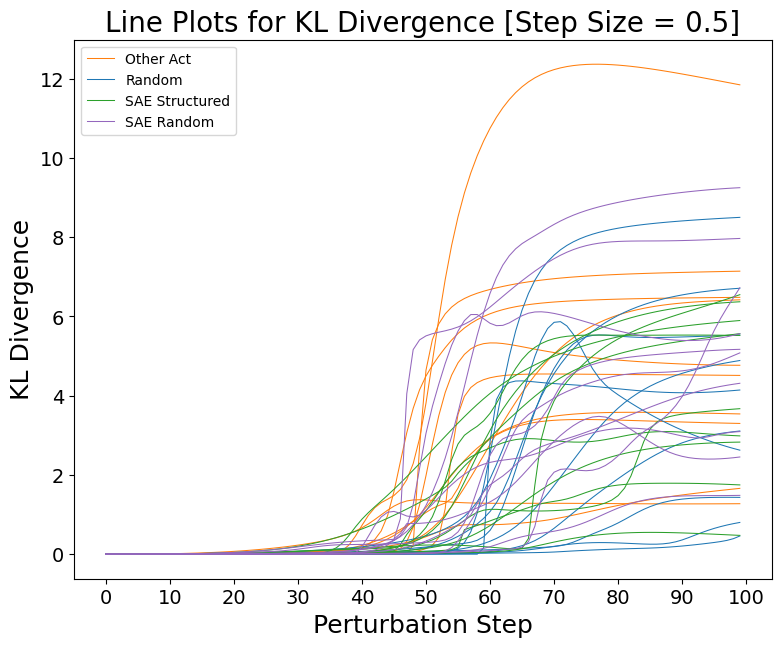

In [19]:
top_k = 10

plt.figure(figsize=(9, 7))  # width, height

name = "other"
for i, kl_div in enumerate(results["kl_div"][name][:top_k]):
    label = None if i > 0 else official_names[name]
    plt.plot(kl_div, color=official_colors[name], label=label, linewidth=0.75)
    # kl_div_mean = torch.stack(results["kl_div"][name]).mean(dim=0)
    # plt.plot(kl_div_mean, color=official_colors[name], label=None, linewidth=2)

name = "random"
for i, kl_div in enumerate(results["kl_div"][name][:top_k]):
    label = None if i > 0 else official_names[name]
    plt.plot(kl_div, color=official_colors[name], label=label, linewidth=0.75)
    # kl_div_mean = torch.stack(results["kl_div"][name]).mean(dim=0)
    # plt.plot(kl_div_mean, color=official_colors[name], label=None, linewidth=2)

name = "synthetic"
for i, kl_div in enumerate(results["kl_div"][name][:top_k]):
    label = None if i > 0 else official_names[name]
    plt.plot(kl_div, color=official_colors[name], label=label, linewidth=0.75)
    # kl_div_mean = torch.stack(results["kl_div"][name]).mean(dim=0)
    # plt.plot(kl_div_mean, color=official_colors[name], label=None, linewidth=2)

name = "bag_of_features"
for i, kl_div in enumerate(results["kl_div"][name][:top_k]):
    label = None if i > 0 else official_names[name]
    plt.plot(kl_div, color=official_colors[name], label=label, linewidth=0.75)
    # kl_div_mean = torch.stack(results["kl_div"][name]).mean(dim=0)
    # plt.plot(kl_div_mean, color=official_colors[name], label=None, linewidth=2)


plt.xlabel("Perturbation Step", fontsize=label_fontsize)
plt.ylabel("KL Divergence", fontsize=label_fontsize)
plt.xticks(np.arange(0, 101, 10), fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)
plt.title("Line Plots for KL Divergence [Step Size = 0.5]", fontsize=title_fontsize)

plt.legend()
plt.show()

L2 Distance

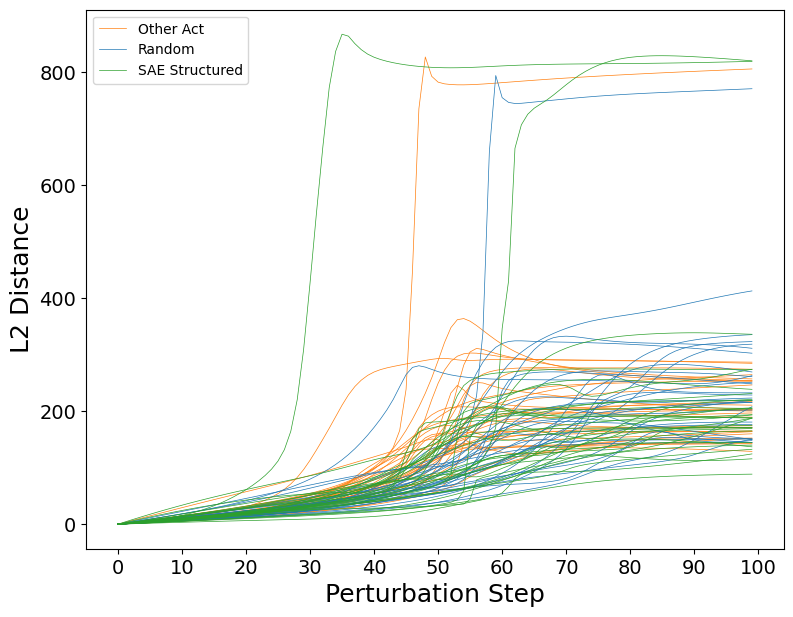

In [21]:
top_k = 30

plt.figure(figsize=(9, 7))  # width, height

name = "other"
for i, l2 in enumerate(results["l2"][name][:top_k]):
    label = None if i > 0 else official_names[name]
    plt.plot(l2, color=official_colors[name], label=label, linewidth=0.5)

name = "random"
for i, l2 in enumerate(results["l2"][name][:top_k]):
    label = None if i > 0 else official_names[name]
    plt.plot(l2, color=official_colors[name], label=label, linewidth=0.5)

name = "synthetic"
for i, l2 in enumerate(results["l2"][name][:top_k]):
    label = None if i > 0 else official_names[name]
    plt.plot(l2, color=official_colors[name], label=label, linewidth=0.5)


plt.xlabel("Perturbation Step", fontsize=label_fontsize)
plt.ylabel("L2 Distance", fontsize=label_fontsize)
plt.xticks(np.arange(0, 101, 10), fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)

plt.legend()
plt.show()

#### Histogram (no CDF)

In [168]:
results["l2_ms"].keys()

dict_keys(['synthetic', 'other', 'random', 'recon_other', 'bag_of_features', 'single_feature'])

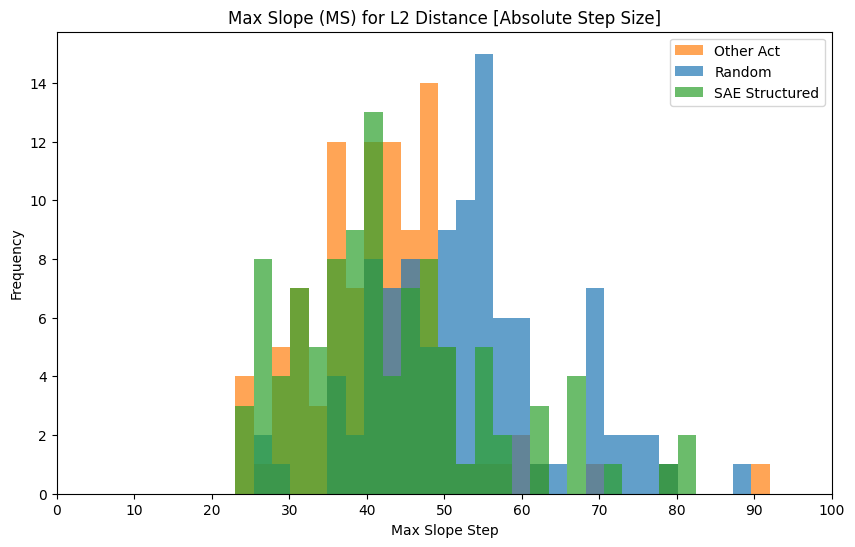

In [169]:
# Create the plot
plt.figure(figsize=(10, 6))

perts_to_plot = ["other", "random", "synthetic"]
what_to_plot = "l2_ms"

all_data = np.concatenate([results[what_to_plot][name] for name in perts_to_plot])
bins = np.linspace(min(all_data), max(all_data), 30)

for name in perts_to_plot:
    plt.hist(
        results[what_to_plot][name],
        bins=bins,
        alpha=0.7,
        label=official_names[name],
        density=False,
        color=official_colors[name],
    )

plt.xticks(np.arange(0, 101, 10))

title = get_plot_title(what_to_plot, is_absolute_step_size)

# Customize the plot
plt.xlabel("Max Slope Step")
plt.ylabel("Frequency")
plt.title(title)
plt.legend()

# Show the plot
plt.show()

#### Histograms

In [22]:
results["l2_ms"].keys()

dict_keys(['synthetic', 'other', 'random', 'recon_other', 'bag_of_features', 'single_feature'])

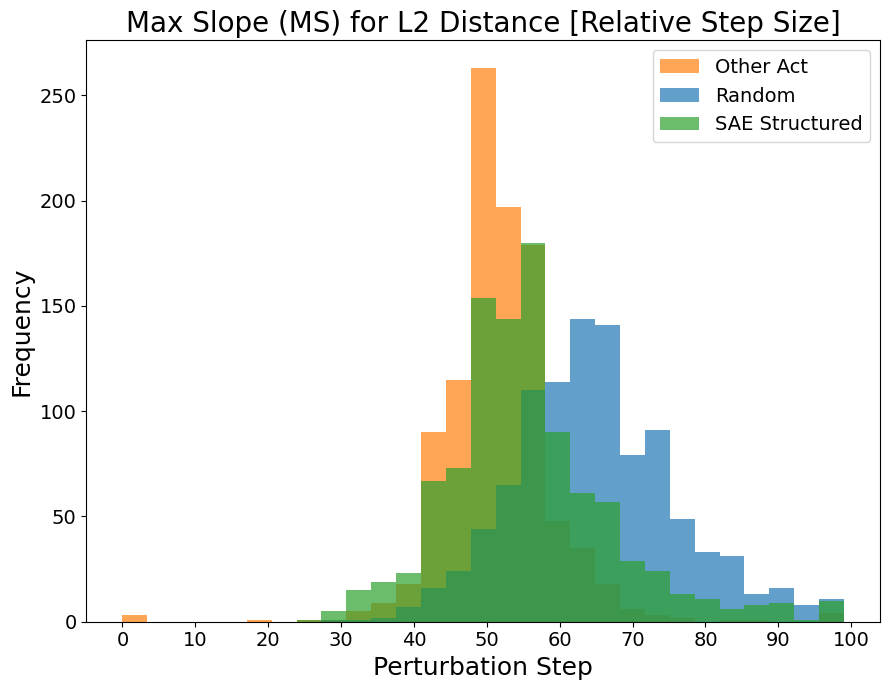

In [24]:
metric = "l2_ms"
perts_to_plot = ["other", "random", "synthetic"]
plot_histogram_paper(results, perts_to_plot, metric, is_absolute_step_size)

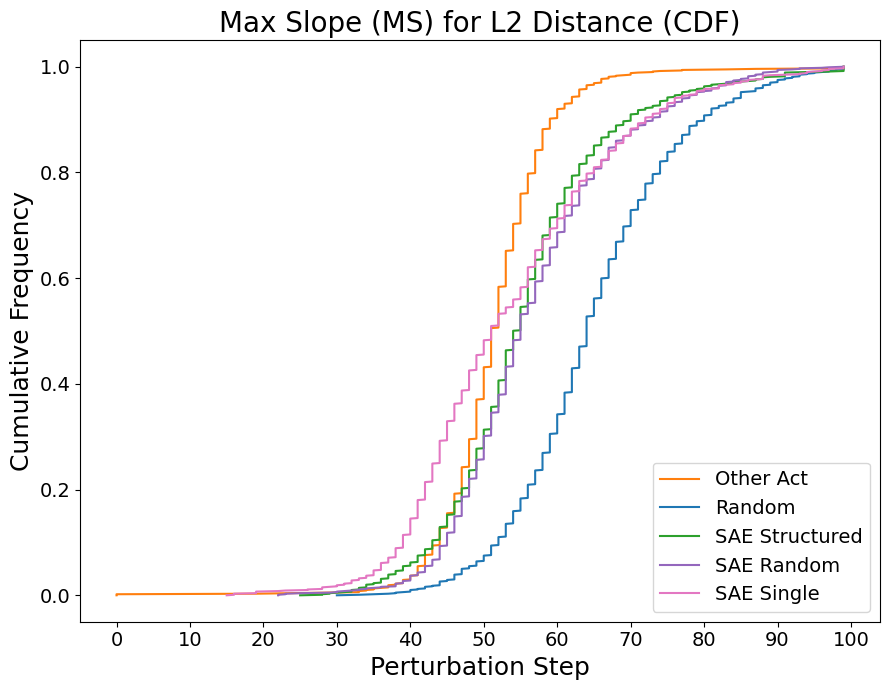

In [27]:
perts_to_plot = ["other", "random", "synthetic", "bag_of_features", "single_feature"]
plot_cdf_paper(results, perts_to_plot, metric)

In [28]:
metric = "l2_ms"
perts_to_plot = ["other", "random", "synthetic"]
print_stats(results, perts_to_plot, metric, to_compare_against="synthetic")

l2_ms Other Act mean: 51.60 std: 7.82
l2_ms Random mean: 65.01 std: 11.19
l2_ms SAE Structured mean: 55.69 std: 11.53

KS Other Act - SAE Structured: 0.214
KS Other Act - random: 0.612


In [29]:
perts_to_plot = ["other", "random", "single_feature"]
print_stats(results, perts_to_plot, metric, to_compare_against="single_feature")

l2_ms Other Act mean: 51.60 std: 7.82
l2_ms Random mean: 65.01 std: 11.19
l2_ms SAE Single mean: 53.60 std: 13.90

KS Other Act - SAE Single: 0.208
KS Other Act - random: 0.612


In [131]:
# matplotlib.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Computer Modern Roman"],
# })

In [142]:
# matplotlib.use('inline')

# # Reset to default parameters
# matplotlib.rcParams.clear()
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)

### Additional Histograms

#### Non-Linear (NL)

In [30]:
def nl_step(values, end_step=10, threshold=20):
    n = len(values)

    # Ensure we have enough data points
    if end_step >= n:
        raise ValueError(
            f"End step {end_step} is out of bounds for the list of length {n}."
        )

    # Calculate the slope (m) using values at start_step and end_step
    x1, y1 = 0, values[0]
    x2, y2 = end_step - 1, values[end_step - 1]
    slope = (y2 - y1) / (x2 - x1)

    # Calculate the intercept (b)
    intercept = y1 - slope * x1

    # Check deviations from step 10 onward
    for i in range(end_step, n):
        # Calculate the expected y value using the linear approximation
        expected_y = slope * i + intercept

        # Calculate the actual y value
        actual_y = values[i]

        # Calculate the percentage deviation
        deviation = abs(actual_y - expected_y) / expected_y * 100

        # Check if the deviation exceeds the threshold
        if deviation > threshold:
            return i - 1
    return n

In [31]:
metric = "l2_nl"
results[metric] = {
    "synthetic": [],
    "other": [],
    "random": [],
    "recon_other": [],
    "bag_of_features": [],
    "single_feature": [],
}

for name, l2s in results["l2"].items():
    nl = [nl_step(pert_l2) for pert_l2 in l2s]
    results[metric][name] = nl

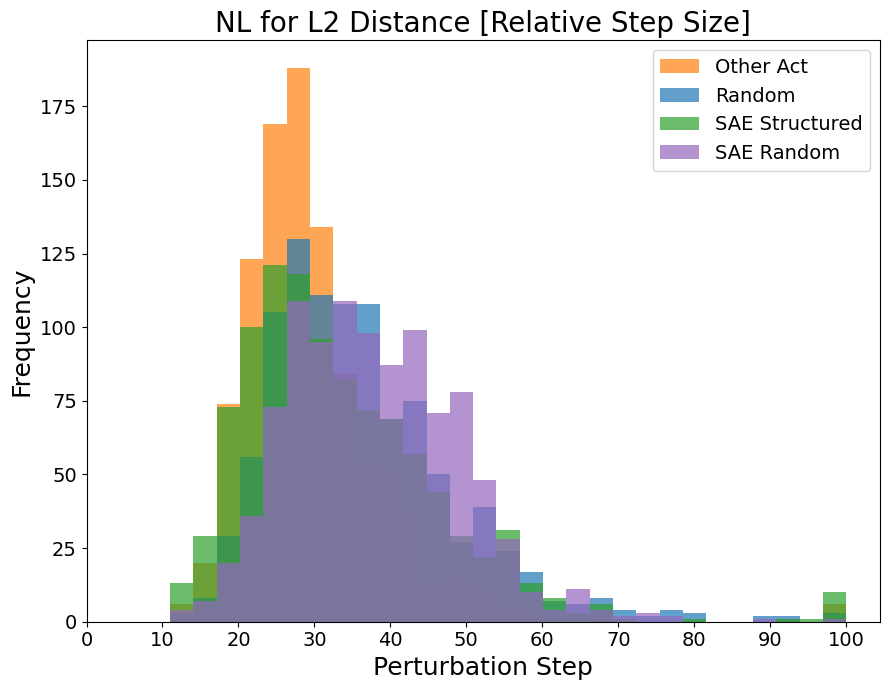

In [32]:
perts_to_plot = ["other", "random", "synthetic", "bag_of_features"]
plot_histogram_paper(results, perts_to_plot, metric, is_absolute_step_size)

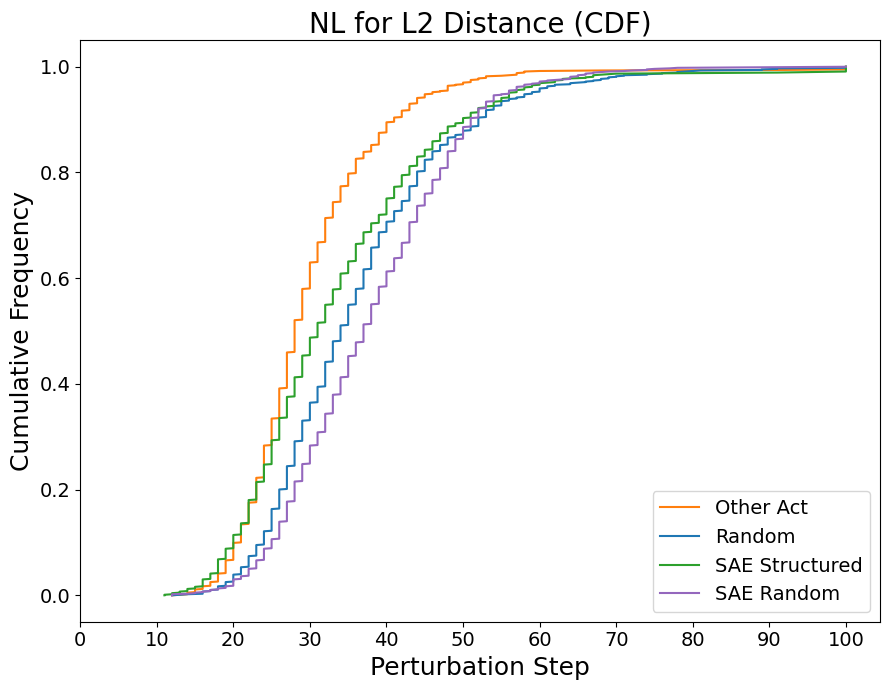

In [33]:
plot_cdf_paper(results, perts_to_plot, metric)

#### Area Under the Curve (AUC)

In [34]:
def calculate_auc(values):
    # Create x values corresponding to the indices of the values
    x = np.arange(len(values))

    # Use numpy's trapezoidal rule to calculate the area under the curve
    auc = np.trapz(values, x)

    return auc


def max_space_ratio_step(values):
    aucs = []
    for i in range(1, len(values)):
        auc = calculate_auc(values[:i])

        if auc == 0:
            aucs.append(0)
            continue
        triangle_area = (values[i - 1] * i) / 2
        aucs.append(triangle_area / auc)
    return np.argmax(aucs[5:]) + 5

In [35]:
results.keys()

dict_keys(['l2', 'l2_ms', 'kl_div', 'kl_div_ms', 'l2_nl'])

In [36]:
results["l2_auc"] = {
    "synthetic": [],
    "other": [],
    "random": [],
    "recon_other": [],
    "bag_of_features": [],
    "single_feature": [],
}

for name, l2s in results["l2"].items():
    auc = [max_space_ratio_step(pert_l2) for pert_l2 in l2s]
    results["l2_auc"][name] = auc

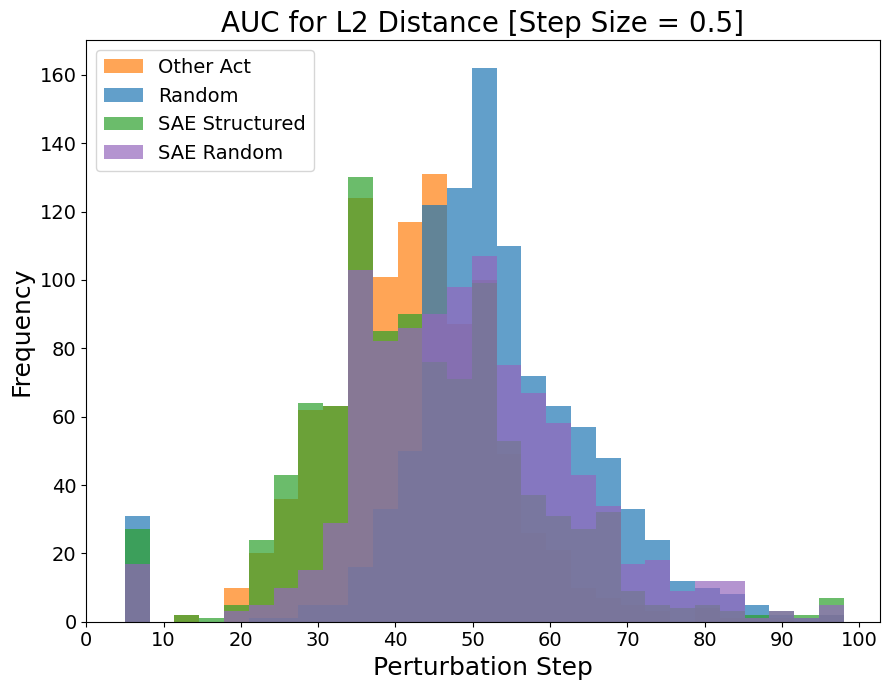

In [301]:
metric = "l2_auc"
perts_to_plot = ["other", "random", "synthetic", "bag_of_features"]
plot_histogram_paper(results, perts_to_plot, metric, is_absolute_step_size)

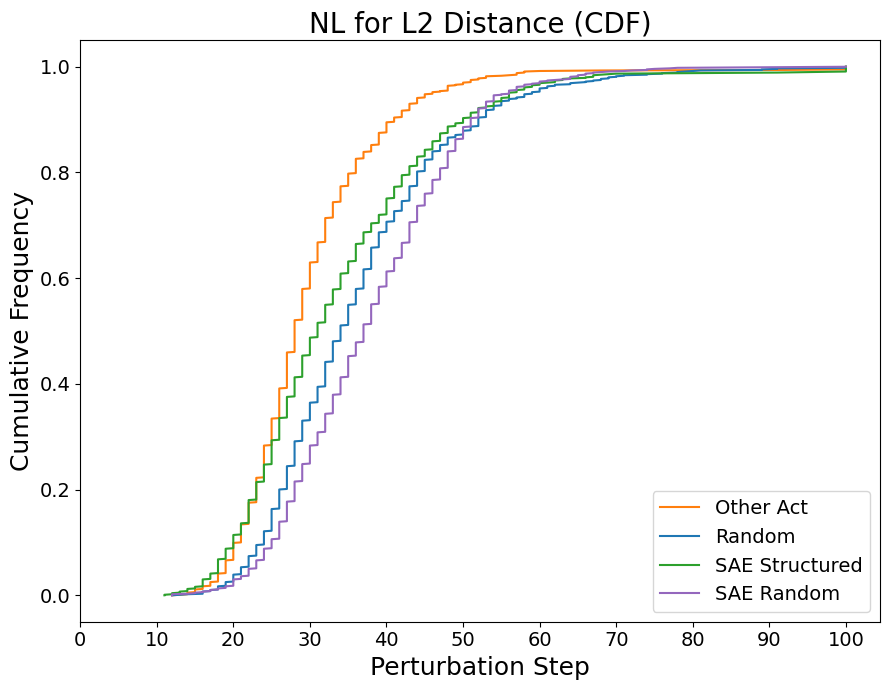

In [37]:
plot_cdf_paper(results, perts_to_plot, metric)

In [38]:
metric = "l2_auc"
perts_to_plot = ["other", "random", "synthetic"]
print_stats(results, perts_to_plot, metric, to_compare_against="synthetic")

l2_auc Other Act mean: 51.98 std: 9.64
l2_auc Random mean: 64.97 std: 16.01
l2_auc SAE Structured mean: 54.84 std: 15.51

KS Other Act - SAE Structured: 0.21
KS Other Act - random: 0.587


#### Initial Slope (IS)

Slope of ffirst 10 steps